In [122]:
library(GDINA);
library(bnlearn);
library(caret)
library(bayestestR)

In [128]:
simdat

I001,I002,I003,I004,I005,I006,I007,I008,I009,I010,I011,I012,I013,I014,I015,I016,I017,I018,I019,I020
1,0,1,1,0,1,0,0,1,1,0,0,0,0,1,1,1,0,0,0
1,0,1,0,0,1,1,0,1,0,0,1,0,0,1,1,1,1,0,0
0,0,1,0,0,0,0,1,1,1,0,1,0,0,1,0,0,0,0,0
1,0,1,1,1,0,0,0,1,1,1,1,1,0,1,0,0,0,0,1
0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,0,1,1
0,1,1,0,0,0,1,1,1,0,1,0,0,0,1,0,0,1,1,0
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1,1,1,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0
1,1,0,1,1,1,0,0,1,0,0,1,0,1,0,0,1,1,0,0
1,0,0,1,0,0,1,0,1,1,0,0,0,0,1,1,1,0,1,0


In [123]:
sigma <- matrix(rep(0.3, times=25), ncol=5)
diag(sigma) <- 1
QMat <- read.csv("q.csv")
guess <- rep(0.3, nrow(QMat));

simdat <- CDM::sim.din(N=10,
                        QMat, guess = guess, slip = guess,
                        Sigma=sigma, rule="DINA")

obs<-simdat$dat
colnames(obs) <- c("x1", "x2", "x3","x4", "x5",
                    "x6", "x7", "x8", "x9", "x10",
                    "x11", "x12", "x13", "x14", "x15",
                    "x16", "x17", "x18", "x19", "x20")
obsdf<- as.data.frame(lapply(as.data.frame(obs),factor))


## This block needs some code cleaning
fulldat <- cbind(simdat$dat, simdat$alpha)
colnames(fulldat)<- c("x1", "x2", "x3","x4", "x5",
                    "x6", "x7", "x8", "x9", "x10",
                    "x11", "x12", "x13", "x14", "x15",
                    "x16", "x17", "x18", "x19", "x20",
                    "a1", "a2","a3","a4","a5")
#fulldat[, colnames(fulldat)] = lapply(fulldat[, colnames(fulldat)], as.factor)
fdf <- as.data.frame(fulldat)
factoreddata <- data.frame(lapply(fdf, factor))

rownames(QMat) <- colnames(obsdf)
colnames(QMat) <- c("a1", "a2", "a3", "a4", "a5")
items <- rownames(QMat)

skills <- colnames(QMat)

itemnames <- rownames(QMat)
itemcomb <- t(combn(itemnames,2))

In [117]:
check_ind <- function(test_type){
    cf = list()
    # Testing when link is present
    # Items that share an attribute should be correlated
    for (i in 1:ncol(QMat)){
        corr_items <-items[as.logical(QMat[,i])]
        test_set <- as.data.frame(t(combn(corr_items,2)))

        for (i in 1:nrow(test_set)){
        testres <- ci.test(test_set$V1[i], test_set$V2[i], data =obsdf, test = test_type)
            if (testres$p.val <= 0.05){
            # The null hypothesis that the given set of nodes are independent
            # When we have p <0.05, we reject the null
                dep <- "1"
            }
            else {
                dep <- "0"
            }
        cf <- rbind(cf,c("1",dep))
        }
    }
    # Testing when link is absent 
    # Theory says obs are independent after we condition on the common attribute  
    for (i in 1:nrow(itemcomb)){
        indc <- as.logical(QMat[itemcomb[i,][1],] * QMat[itemcomb[i,][2],])
        tmp <- ci.test(itemcomb[i,][1], itemcomb[i,][2],skills[indc], 
                    test = test_type, data=factoreddata)
        if(tmp$p.val <= 0.05){
            dep <- "1" 
        }
        else {
        dep <-"0"
        }
        cf <- rbind(cf,c("0",dep))
    }
    return(cf)
}

In [124]:
check_bf <- function(){
    cf = list()
    # Testing when link is present
    # Items that share an attribute should be correlated
    for (i in 1:ncol(QMat)){
        corr_items <-items[as.logical(QMat[,i])]
        test_set <- as.data.frame(t(combn(corr_items,2)))

        for (i in 1:nrow(test_set)){
        m1 <- glm(get(test_set$V1[i])~ 1 + get(test_set$V2[i]), data = as.data.frame(obs), family = "binomial")
        m2 <- glm(get(test_set$V1[i])~ 1, data = as.data.frame(obs), family = "binomial")
        m1bic <- -2*as.numeric(logLik(m1))
        m2bic <- -2*as.numeric(logLik(m2))
        bf <- bic_to_bf(m2bic, denominator = m1bic)
    
            if (bf > 0){
            # The null hypothesis that the given set of nodes are independent
            # When we have p <0.05, we reject the null
                dep <- "1"
            }
            else {
                dep <- "0"
            }
        cf <- rbind(cf,c("1",dep))
        }
    }
    # Testing when link is absent 
    # Theory says obs are independent after we condition on the common attribute  
    for (i in 1:nrow(itemcomb)){
        indc <- as.logical(QMat[itemcomb[i,][1],] * QMat[itemcomb[i,][2],])
        
        cond_set <- skills[indc]
        features <- append(itemcomb[i,][2], cond_set)
        features1 <- append(features,1)
        target <- itemcomb[i,][1]
        rhs<- paste(features1,collapse = "+")
        f <- as.formula(paste(target, rhs, sep ="~"))
        m2 <- glm(f, data = as.data.frame(fulldat), family = "binomial")


        features0 <- append(cond_set,1)
        rhs0<- paste(features0,collapse = "+")
        f0 <- as.formula(paste(target, rhs0, sep ="~"))
        m1 <- glm(f0, data = as.data.frame(fulldat), family = "binomial")
        
        # Here we are testing M1 [P(X1|skill)] against M2 [P(X1|X2,skill)]
        # If bayesfactor prefer M1 over M2, that means X1 & X2 are independent given the common attribute
        m1bic <- -2*as.numeric(logLik(m1))
        m2bic <- -2*as.numeric(logLik(m2))
        bf <- bic_to_bf(m2bic, denominator = m1bic)
        if(bf < 0){
            dep <- "1" 
        }
        else {
        dep <-"0"
        }
        cf <- rbind(cf,c("0",dep))
    }
    return(cf)
}

In [125]:
res <- check_bf()

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

In [126]:
trues<- as.data.frame(factor(res[,1], levels = c('1','0')))
preds<- as.data.frame(factor(res[,2], levels = c('1','0')))
cdf <- data.frame(trues,preds)
colnames(cdf) <- c("true_val", "pred_val")

In [127]:
confusionMatrix(data=cdf$pred_val, reference = cdf$true_val)

Confusion Matrix and Statistics

          Reference
Prediction   1   0
         1 157   0
         0   0 190
                                     
               Accuracy : 1          
                 95% CI : (0.9894, 1)
    No Information Rate : 0.5476     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0000     
            Specificity : 1.0000     
         Pos Pred Value : 1.0000     
         Neg Pred Value : 1.0000     
             Prevalence : 0.4524     
         Detection Rate : 0.4524     
   Detection Prevalence : 0.4524     
      Balanced Accuracy : 1.0000     
                                     
       'Positive' Class : 1          
                                     

In [112]:
library(pROC)

In [113]:
roc_score <-roc(as.numeric(cdf$true_val), as.numeric(cdf$pred_val))


Setting levels: control = 1, case = 2

Setting direction: controls < cases



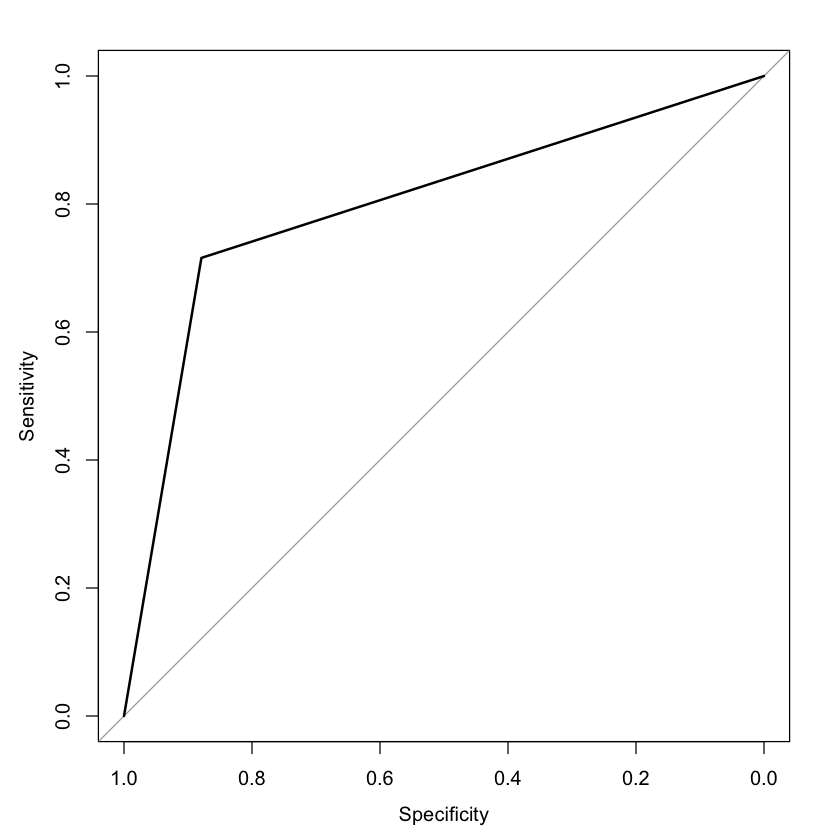

In [114]:
plot(roc_score)

In [115]:
auc(roc_score)

Area under the curve: 0.7974